# Final Project:   MNIST Classifiers

CUNY MSDA - DATA 602: Advanced Programming Techniques<br>
_Author - Walt Wells_

## Resources

Some words about the OSDC...

## Environment Prep

In [1]:
import os
import struct
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline

## Data Import and Preparation

In [2]:
def read(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set as a pandas data frame. 
    The first column is the label/class, the other 784 columns are the pixel values.  
    Uses code liberally from https://gist.github.com/akesling/5358964, but works to build
    a table similar to the Kaggle digit recognizer dataset: https://www.kaggle.com/c/digit-recognizer
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError, "dataset must be 'testing' or 'training'"
    
    # get labels
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.uint8)

    # get pixel values
    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), 1, 784)
        img = img.tolist()
        img = list(itertools.chain(*img))
    
    data = [] #initialize list
    
    # get row for DF
    def get_img(idx): 
        row = img[idx]
        row.insert(0, lbl[idx])
        return row

    # populate list with rows for each image
    for i in xrange(len(lbl)):
        data.append(get_img(i))
    
    # convert to df
    df = pd.DataFrame(data)
    df.rename(columns={0:'label'}, inplace=True)
    return df

### Import Train and Testing Data

In [3]:
mtrain = read("training")
mtest = read("testing")
print "Training Data: ", mtrain.shape
print "Testing Data: ", mtest.shape
#mtrain.head(5)

Training Data:  (60000, 785)
Testing Data:  (10000, 785)


### Review Training and Test Label Distributions

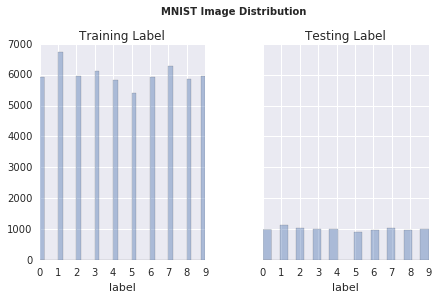

In [4]:
f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
plt.suptitle('MNIST Image Distribution', fontweight='bold')
sns.distplot(mtrain.label, kde=False, ax=ax1).set_title('Training Label');
sns.distplot(mtest.label, kde=False, ax=ax2).set_title('Testing Label');
plt.subplots_adjust(top=.85, bottom=0.1, left=0.05, right=0.95, hspace=0.8,
                    wspace=0.35)

## Image Visualization

In [5]:
def rowconverter(df, idx):
    """
    given a df and a index, get a label for the image, and convert 
    back to a 28^2 np.array
    """
    row = df.loc[[idx]]
    label = row.iloc[0]['label']
    row.pop('label')
    image = row.as_matrix().reshape(28,28)
    return label, image

# Both of the visualization tools below contain code taken liberally from
# https://gist.github.com/akesling/5358964

def ascii_show(image):
    """
    Show pixel values in formation
    """
    for y in image[1]:
         row = ""
         for x in y:
             row += '{0: <4}'.format(x)
         print row
        
def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    title = "Image Label : " + str(image[0])
    fig = plt.figure()
    plt.title(title)
    imgplot1 = plt.imshow(image[1], cmap=mpl.cm.Greys)
    imgplot1.set_interpolation('nearest')
    plt.show()

### Visualize Random Example in Training Data

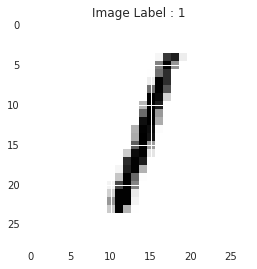

0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   19  209 229 35  0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   145 250 128 0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   161 217 0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   36  253 217 0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   162 253 188 0   0   0   0   0   0   

In [6]:
img = rowconverter(mtrain, randint(0,len(mtrain)))

show(img)
ascii_show(img)

## Simple Classifier

### Mean Pixel Location

In [7]:
meanClass = mtrain.groupby(['label']).mean()
meanClass.reset_index(level=0, inplace=True)

### Visualize Mean Results

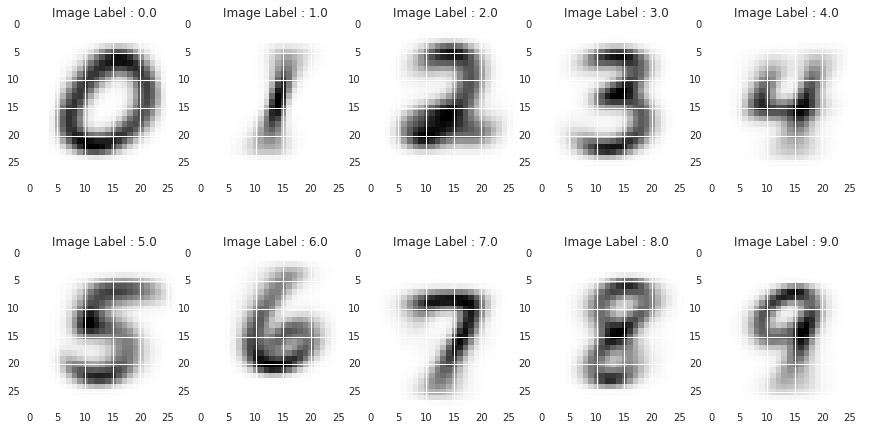

In [8]:
fig, axarr = plt.subplots(2,5, figsize=(15,8))
fig.subplots_adjust(hspace = .05, wspace=.1)
axs = axarr.ravel()

for i in range(len(meanClass)):
    img = rowconverter(meanClass, i)
    title = "Image Label : " + str(img[0])
    axs[i].set_title(title)
    imgplot = axs[i].imshow(img[1])
    imgplot.set_interpolation('nearest')

### Get Distances

#### Euclidean Norm
* $m$ = our meanClass dataset
* $t$ = a single vector representing an image

$||m - t||_2$

Here we want the _lowest_ distance to determine the correct prediction. 

In [11]:
def eucDist(single):
    """
    given an image, calculate the Euclidean distance to the values
    in our meanClass dataset, and return a prediction and value
    """
    label = np.asscalar(single['label'])

    result = pd.DataFrame(meanClass.values - single.values, columns=meanClass.columns)
    result.drop(result.columns[[0]], axis=1, inplace=True)

    result = np.square(result)
    eucdist = np.sqrt(result.sum(axis=1))
    eucdist

    predict, dist = eucdist.idxmin(), eucdist.min()
    #print type(label)
    #print type(predict)
    
    return [label, predict, dist]

#### Cosine Distance
$\frac{m \times t}{||m||_2 \times ||t||_2}$

Here we want the _greatest_ distance value (closest to 1) to determine the correct prediction. 

In [102]:
def cosDist(single):
    """
    given an image, calculate the Cosine distance to the values
    in our meanClass dataset, and return a prediction and value
    """
    m = meanClass.copy()  ## should be a cleaner way to do this?
    m.drop(m.columns[[0]], axis=1, inplace=True)

    label = np.asscalar(single['label'])

    t = pd.DataFrame(single)

    t.drop(['label'], inplace=True)
    tran_t = t.transpose()

    numerator = np.dot(m, t).T

    m_2 = np.sqrt(np.square(m).sum(axis=1))
    t_2 = np.sqrt(np.square(tran_t).sum(axis=1))
    
    denominator = m_2.values * t_2.values

    cosdist = np.divide(numerator, denominator)
    predict, dist = np.argmax(cosdist), cosdist.max()
    
    return [label, predict, dist]

### Predict a single image

In [108]:
img = mtest[0:1]
euc_img = img.apply(eucDist, axis=1)
cos_img = img.apply(cosDist, axis=1)

print "Test Class: ", euc_img[0][0]
print "---------------------------------------"
print "Euclidean Distance"
print "Predicted Class: ", euc_img[0][1], " |  Distance of: ", euc_img[0][2]
print "Is this prediction correct: ", euc_img[0][1] == euc_img[0][1]
print "---------------------------------------"
print "Cosine Distance"
print "Predicted Class: ", cos_img[0][1], " |  Distance of: ", cos_img[0][2]
print "Is this prediction correct: ", cos_img[0][0] == cos_img[0][1]

 Test Class:  7
---------------------------------------
Euclidean Distance
Predicted Class:  7  |  Distance of:  1221.30925287
Is this prediction correct:  True
---------------------------------------
Cosine Distance
Predicted Class:  7  |  Distance of:  0.783245174237
Is this prediction correct:  True


### Predict all test data

In [110]:
euc_results = mtest.apply(eucDist, axis=1)
cos_results = mtest.apply(cosDist, axis=1)
#sub = mtest[1:5]
#test_results = sub.apply(cosDist, axis=1)
#test_results

In [112]:
print euc_results.head(5)
print cos_results.head(5)

0    [7, 7, 1221.30925287]
1    [2, 2, 2048.53150525]
2    [1, 1, 897.925426003]
3    [0, 0, 1568.43174815]
4    [4, 4, 1533.68057641]
dtype: object
0    [7, 7, 0.783245174237]
1    [2, 2, 0.592661631042]
2    [1, 1, 0.792132823803]
3    [0, 0, 0.850992881213]
4    [4, 4, 0.657408501547]
dtype: object


## Describe Results

## Expand/Improve above Model?   Use existing libraries to model other classifer algorithms?

## References

* When Life is Linear, Tim Chartier
* https://www.kaggle.com/archaeocharlie/digit-recognizer/a-beginner-s-approach-to-classification
* https://martin-thoma.com/classify-mnist-with-pybrain/
* https://gist.github.com/akesling/5358964
* http://colah.github.io/posts/2014-10-Visualizing-MNIST/
* http://stackoverflow.com/questions/17210646/python-subplot-within-a-loop-first-panel-appears-in-wrong-position
* https://www.tensorflow.org/get_started/mnist/beginners
* https://en.wikipedia.org/wiki/Cosine_similarity
* https://en.wikipedia.org/wiki/Euclidean_distance